# Loading Hyperbolic Orbits into REBOUND

Imagine we have a table of orbital elements for comets (kindly provided by Toni Engelhardt).  Let's first load it and display it.  

In [1]:
class ListTable(list):     # this is just to nicely display the table (credit: Caleb Madrigal)
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

table = ListTable()
# this is what each column represents
table.append(['tracklet_id', 'e', 'q[AU]', 'i[deg]', 'Omega[deg]', 'argperi[deg]', 't_peri[MJD, days]', 'epoch_of_elements[MJD, days]', 'epoch_of_observation[MJD, days]'])

import numpy as np
comets = np.genfromtxt("comets.txt", skip_header=1, dtype=None) # load the table
for comet in comets:
    table.append(comet)
table

tracklet_id,e,q[AU],i[deg],Omega[deg],argperi[deg],"t_peri[MJD, days]","epoch_of_elements[MJD, days]","epoch_of_observation[MJD, days]"
168026,12.181214,15.346358,136.78247,37.581438,268.412314,54776.806093,53371.0,55516.41727
21170,2.662235,2.013923,140.646538,23.02949,46.292039,54336.126288,53371.0,53673.44043
189298,15.503013,11.550314,20.042232,203.240743,150.855761,55761.641176,53371.0,55718.447145
72278,34.638392,24.742323,157.984412,126.43154,178.612758,54382.158401,53371.0,54347.240445
109766,8.832472,9.900228,144.857801,243.102255,271.345342,55627.501618,53371.0,54748.37722


We now want to add these to simulation(s).  The first thing to do is set the units, which have to be consistent throughout.  Here we have a table in AU and days, so we'll use the gaussian gravitational constant (AU, days, solar masses).  

In [2]:
import rebound
sim = rebound.Simulation()
k = 0.01720209895 # Gaussian constant
sim.G = k**2

We would then add the giant planets to the simulation.  You could for example query JPL HORIZONS for the states of the planets at each comet's corresponding epoch of observation (see [Horizons.ipynb](Horizons.ipynb)).  Here we set up toy masses and orbits for Jupiter & Saturn:

In [3]:
sim.add(m=1.) # Sun
sim.add(m=1.e-3, a=5.) # Jupiter
sim.add(m=3.e-4, a=10.) # Saturn

Let's write a function that takes a comet from the table and returns an orbit:

In [4]:
def getOrbit(comet_elem):
    o = rebound.Orbit()
    o.e = comet_elem[1]
    o.a = comet_elem[2]/(1.-o.e) # q = a(1-e)
    o.inc = comet_elem[3]*np.pi/180. # have to convert to radians
    o.Omega = comet_elem[4]*np.pi/180.
    o.omega = comet_elem[5]*np.pi/180.
    o.T = comet_elem[6] # time of pericenter passage
    return o

We can now set up the first comet.  We begin by setting the simulation time to the epoch of observation (when our orbital elements are valid):

In [5]:
comet_elem = comets[0]
sim.t = comet_elem[-1] # last column is the time of observation
o = getOrbit(comet_elem)
sim.add(a=o.a, e=o.e, inc=o.inc, Omega=o.Omega, omega=o.omega, T=o.T)

By default, REBOUND adds and outputs particles in jacobi orbital elements.  Typically orbital elements for comets are heliocentric.  Mixing the two will give you relative errors in elements, positions etc. of order the mass ratio of Jupiter to the Sun ($\sim 0.001$).  If that matters to you, you should additionally pass `primary=sim.particles[0]` in the `add` call above, and you'd output with:

In [6]:
comet = sim.particles[3]
print(comet.calculate_orbit(primary=sim.particles[0]))

<rebound.Orbit instance, a=-1.3693531710375346 e=12.201677899305905 inc=2.386856395628858 Omega=0.6563769038524557 omega=-1.5984922294899382 f=0.662947294342688>


You'll notice that, as expected, these elements differ from the ones in the table above by $\sim 0.001$ because we added in Jacobi, and outputted heliocentric.  If you're consistent, they'll be the same.  We can quickly plot what the system looks like:

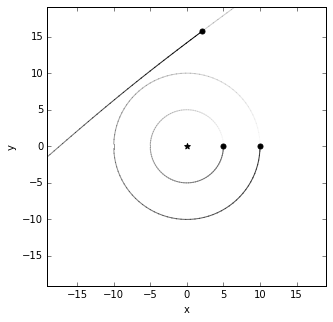

In [7]:
%matplotlib inline
fig = rebound.OrbitPlot(sim, trails=True)

Now we just integrate until whatever final time we’re interested in:

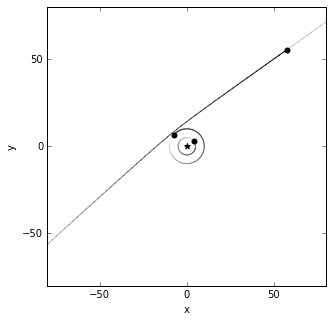

In [8]:
tfinal = 60000 # Final time in days since J2000
sim.integrate(tfinal)
fig = rebound.OrbitPlot(sim, trails=True)

In [9]:
print(comet.orbit)

<rebound.Orbit instance, a=-1.3725067517418916 e=12.181305454717414 inc=2.387303295568815 Omega=0.6559203102943116 omega=-1.598504146646605 f=1.445539842442101>


The osculating elements change slightly because of the presence of the giant planets.  For fun, let's add them all to a simulation (wouldn't actually make sense because the elements are for different observation epochs!)

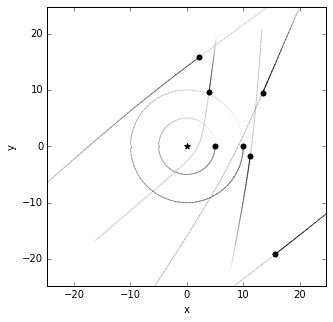

In [10]:
import rebound
sim = rebound.Simulation()
k = 0.01720209895 # Gaussian constant
sim.G = k**2
sim.add(m=1.) # Sun
sim.add(m=1.e-3, a=5.) # Jupiter
sim.add(m=3.e-4, a=10.) # Saturn
for comet_elem in comets:
    sim.t = comet_elem[-1] # last column is the time of observation
    o = getOrbit(comet_elem)
    sim.add(a=o.a, e=o.e, inc=o.inc, Omega=o.Omega, omega=o.omega, T=o.T)
fig = rebound.OrbitPlot(sim, trails=True)